# Modelagem Preditiva de Séries Temporais - Em Python

# <font color='blue'>Deep Learning - Recurrent Neural Networks (RNN)</font>


Todas as aulas deste curso foram adaptadas da timeline da Comunidade no Portal da DSA: www.datascienceacademy.com.br

# Redes Neurais Recorrentes LSTM - Long Short-Term Memory 

Este Notebook está dividido nas seguintes etapas. Clique no título da etapa para acessá-la diretamente.

* [Etapa 1](#etapa1): Conjunto de dados
* [Etapa 2](#etapa2): Importar as Bibliotecas
* [Etapa 3](#etapa3): Criar o Modelo
* [Etapa 4](#etapa4): Testar o Modelo
* [Etapa 5](#etapa5): Realizar as Previsões

# Prevendo Séries Temporais com LSTMs e Time Steps

Você pode ter notado que a preparação de dados para a rede LSTM inclui etapas de tempo (time steps). Alguns problemas de sequência podem ter uma série variada de etapas de tempo por amostra. Por exemplo, você pode ter medidas de uma máquina industrial levando a um ponto de falha ou a um ponto de aumento de performance. Cada incidente seria uma amostra, as observações que levaram ao evento seriam os passos de tempo e as variáveis observadas seriam os recursos. Passos de tempo fornecem outras forma de tratar nosso problema de séries temporais. Como o exemplo acima usando o método Window, podemos ter passos de tempo anteriores em nossas séries temporais como entradas para prever a saída no próximo passo.

Em vez de reescrever as observações passadas como características de entrada separadas, podemos usá-las como passos de tempo de uma característica (atributo) de entrada, que é realmente um enquadramento mais preciso do problema. Podemos fazer isso usando a mesma representação de dados que no exemplo anterior do método window, exceto quando fazemos o reshape dos dados, onde definimos as colunas como a dimensão time step e alteramos a dimensão das features de volta para 1.

O método window cria novos recursos, como novos atributos para o modelo, enquanto os timesteps são uma sequência dentro de um lote para um determinado recurso.

<a id = 'etapa1'></a>
## Etapa 1: Conjunto de dados

Previsão de Capacidade do Mainframe - Consumo dos Jobs do Broker

Usaremos conjuntos de dados que mostram o Consumo dos Jobs do Broker. 

<a id='etapa2'></a>
## Etapa 2: Importar as Bibliotecas

In [1]:
# Importa TF2
import tensorflow as tf
tf.__version__

'2.10.0'

In [2]:
# Imports
import math
import numpy
import pandas as pd
import os
import io
import requests

from pandas.tseries.offsets import DateOffset
from time import time
from datetime import datetime

# Importa Keras TF2
from tensorflow import keras   
from tensorflow.keras import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.models import load_model

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error


# Imports para visualização de dados
import matplotlib.pyplot as plt
import matplotlib as m

# Imports para formatação dos gráficos
plt.style.use('fivethirtyeight')
m.rcParams['axes.labelsize'] = 14
m.rcParams['xtick.labelsize'] = 12
m.rcParams['ytick.labelsize'] = 12
m.rcParams['text.color'] = 'k'
from pylab import rcParams
rcParams['figure.figsize'] = 20, 10

In [3]:
# Converte array em matriz
def create_dataset(dataset, look_back=1):
    dataX, dataY = [], []
    for i in range(len(dataset)-look_back-1):
        a = dataset[i:(i+look_back), 0]
        dataX.append(a)
        dataY.append(dataset[i + look_back, 0])
    return numpy.array(dataX), numpy.array(dataY)

In [4]:
# Define o PATH onde estão os dados
save_path = "./save"

# Random seed 
numpy.random.seed(7)

look_back = 10

<a id='etapa3'></a>
## Etapa 3: Criar o Modelo

In [5]:
# Carrega os dataframe
dataframe = pd.read_csv("./CSV/pipaColBrokerDia.csv")
dataframe['DATA'] = pd.to_datetime(dataframe.DATA, format = '%Y-%m-%dT%H:%M:%S.%fZ')
dataframe.rename(columns={'DATA': 'Data'}, inplace=True)
dataframe = dataframe[['Data','BROKER','SERVICE_NAME','SERVICE_CLASS','PROGRAMA', 'QUANTIDADE']]
dataframe.rename(columns={'BROKER': 'Broker', 'SERVICE_NAME': 'Service_name', 'SERVICE_CLASS': 'Service_class',
                      'PROGRAMA': 'Programa', 'QUANTIDADE': 'Quantidade'}, inplace=True)
dataframe

,Data,Broker,Service_name,Service_class,Programa,Quantidade
0,2021-11-27,ETB160,DETRAN,SDGX,NSDGX047,6
1,2021-11-27,ETB160,DETRAN,SDGX,NSDAKG12,1
2,2021-11-27,ETB160,DETRAN,SDGX,NSDAKQ08,1
3,2021-11-27,ETB160,DETRAN,SDGX,NSDAKQ07,1
4,2021-11-27,ETB160,DETRAN,SDGX,NSDGX414,1
...,...,...,...,...,...,...
71289,2022-10-24,ETB170,PORTALDETRAN,SDGX,NSDGX500,217
71290,2022-10-24,ETB170,PORTALDETRAN,SDGX,NSDGX495,9
71291,2022-10-24,ETB170,PORTALDETRAN,SDGX,NSDGX469,121
71292,2022-10-24,ETB170,PORTALDETRAN,SDGX,NSDGX467,12


In [6]:
dataframe.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 71294 entries, 0 to 71293
Data columns (total 6 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   Data           71294 non-null  datetime64[ns]
 1   Broker         71294 non-null  object        
 2   Service_name   71294 non-null  object        
 3   Service_class  71294 non-null  object        
 4   Programa       71294 non-null  object        
 5   Quantidade     71294 non-null  int64         
dtypes: datetime64[ns](1), int64(1), object(4)
memory usage: 3.3+ MB


In [7]:
# Carregando os dados
# Podemos carregar este conjunto de dados facilmente usando a biblioteca Pandas. Não estamos interessados na data,
# pois que cada observação é separada pelo mesmo intervalo de um mês. Portanto, quando
# carregamos o conjunto de dados, podemos excluir a primeira coluna. O conjunto de dados baixado também tem rodapé
# com informações que podemos excluir com o argumento skipfooter para pandas.read_csv() 
# Uma vez carregado, podemos plotar facilmente todo o conjunto de dados. 

datasetfull = dataframe.copy()

filtro1 = datasetfull['Broker']=='ETB170'
filtro2 = datasetfull['Service_name']=='PORTALDETRAN'
filtro3 = datasetfull['Programa']=='NSDGX500'
datasetfull = datasetfull[filtro1 & filtro2 & filtro3]

datasetfull = datasetfull.rename_axis('index').reset_index()
datasetfull.drop(columns=['index','Broker','Service_name','Service_class','Programa'], inplace=True)
datasetfull

,Data,Quantidade
0,2021-11-27,96
1,2021-11-26,82
2,2021-11-25,50
3,2021-11-24,50
4,2021-11-23,100
...,...,...
572,2022-10-21,78
573,2022-10-22,65
574,2022-10-24,79
575,2022-10-25,176


In [8]:
# Remove as linhas com as datas duplicadas
# Vamos transformar a coluna de data no índice do conjunto de dados. Isso vai facilitar nosso trabalho mais a frente.
# inclui dados missing com a interpolação 

datasetfull.drop_duplicates(subset='Data', inplace=True)
datasetfull = datasetfull.set_index('Data')
datasetfull = datasetfull.resample('D').interpolate()
datasetfull

,Quantidade
Data,
2021-10-26,162.0
2021-10-27,66.0
2021-10-28,58.0
2021-10-29,44.0
2021-10-30,83.0
...,...
2022-10-21,207.0
2022-10-22,22.0
2022-10-23,50.5


In [9]:
datasetfull = datasetfull.values
datasetfull = datasetfull.astype('float32')

In [10]:
# Dados
datasetfull

array([[162.      ],
       [ 66.      ],
       [ 58.      ],
       [ 44.      ],
       [ 83.      ],
       [ 84.5     ],
       [ 86.      ],
       [ 87.      ],
       [ 88.      ],
       [ 63.      ],
       [212.      ],
       [ 64.      ],
       [ 90.5     ],
       [117.      ],
       [ 50.      ],
       [115.      ],
       [ 54.      ],
       [ 92.      ],
       [124.      ],
       [103.333336],
       [ 82.666664],
       [ 62.      ],
       [106.      ],
       [ 33.      ],
       [120.      ],
       [107.      ],
       [145.5     ],
       [184.      ],
       [100.      ],
       [ 50.      ],
       [ 50.      ],
       [ 82.      ],
       [ 96.      ],
       [ 83.      ],
       [ 70.      ],
       [ 98.      ],
       [  4.      ],
       [111.      ],
       [194.      ],
       [  3.      ],
       [ 48.5     ],
       [ 94.      ],
       [ 95.      ],
       [135.      ],
       [ 14.      ],
       [  4.      ],
       [215.      ],
       [109. 

In [11]:
# Split em treino e teste
train_size = int(len(datasetfull) * 0.75)
test_size = len(datasetfull) - train_size
dataset, test = datasetfull[0:train_size,:], datasetfull[train_size:len(datasetfull),:]

In [12]:
# Normaliza os dados
# As LSTMs são sensíveis à escala dos dados de entrada, especificamente quando funções de ativação sigmoide (padrão)
# ou tanh são usadas. Pode ser uma boa prática redimensionar os dados para o range de 0 a 1, 
# também chamado de normalização. Podemos normalizar facilmente o conjunto de dados usando a classe MinMaxScaler do scikit-learn
scaler = MinMaxScaler(feature_range = (0, 1))
dataset = scaler.fit_transform(dataset)

In [13]:
# Split em treino e validação
train_size = int(len(dataset) * 0.67)
valid_size = len(dataset) - train_size
train, valid = dataset[0:train_size,:], dataset[train_size:len(dataset),:]

In [14]:
dataset.shape

(273, 1)

In [15]:
train.shape

(182, 1)

In [16]:
valid.shape

(91, 1)

In [17]:
test.shape

(92, 1)

In [18]:
# Reshape em X=t e Y=t+1
trainX, trainY = create_dataset(train, look_back)
validX, validY = create_dataset(valid, look_back)

# Reshape do input para: [samples, time steps, features]
# Time steps
trainX = numpy.reshape(trainX, (trainX.shape[0], trainX.shape[1], 1))
validX = numpy.reshape(validX, (validX.shape[0], validX.shape[1], 1))

In [19]:
# Cria o modelo LSTM
# Agora estamos prontos para projetar nossa rede LSTM para esse problema. A rede tem uma
# camada visível com 1 entrada, uma camada oculta com 4 blocos LSTM ou neurônios e uma camada de saída
# que faz uma previsão de valor único. A função de ativação sigmoid padrão é usada para
# os blocos de memória LSTM. A rede é treinada em 200 épocas e um tamanho de lote (batch_size) de 1 é usado.

# Treinamento
start = time()
current_time = datetime.now().strftime("%H:%M:%S")
print("Hora de Início =", current_time)

model = Sequential()
model.add(LSTM(4, input_shape = (None, 1)))
model.add(Dense(1))
model.compile(loss = 'mean_squared_error', optimizer = 'adam')

# Early stoppping
monitor = EarlyStopping(monitor = 'val_loss', min_delta = 1e-3, patience = 5, verbose = 1, mode = 'auto')

model.fit(trainX, trainY, epochs = 200, batch_size = 1, verbose = 2)

#model.fit(trainX, trainY, validation_data = (validX, validY), callbacks = [monitor], verbose = 2, epochs = 200)


current_time = datetime.now().strftime("%H:%M:%S")
print("\nHora de Término =", current_time)    
print ('Tempo gasto: %s segundos' % str(time() - start))

Hora de Início = 22:12:29
Epoch 1/200
171/171 - 4s - loss: 0.1369 - 4s/epoch - 23ms/step
Epoch 2/200
171/171 - 1s - loss: 0.0454 - 995ms/epoch - 6ms/step
Epoch 3/200
171/171 - 1s - loss: 0.0419 - 993ms/epoch - 6ms/step
Epoch 4/200
171/171 - 1s - loss: 0.0410 - 966ms/epoch - 6ms/step
Epoch 5/200
171/171 - 1s - loss: 0.0401 - 957ms/epoch - 6ms/step
Epoch 6/200
171/171 - 1s - loss: 0.0397 - 959ms/epoch - 6ms/step
Epoch 7/200
171/171 - 1s - loss: 0.0389 - 947ms/epoch - 6ms/step
Epoch 8/200
171/171 - 1s - loss: 0.0384 - 961ms/epoch - 6ms/step
Epoch 9/200
171/171 - 1s - loss: 0.0383 - 951ms/epoch - 6ms/step
Epoch 10/200
171/171 - 1s - loss: 0.0376 - 957ms/epoch - 6ms/step
Epoch 11/200
171/171 - 1s - loss: 0.0373 - 950ms/epoch - 6ms/step
Epoch 12/200
171/171 - 1s - loss: 0.0371 - 934ms/epoch - 5ms/step
Epoch 13/200
171/171 - 1s - loss: 0.0370 - 977ms/epoch - 6ms/step
Epoch 14/200
171/171 - 1s - loss: 0.0367 - 1s/epoch - 6ms/step
Epoch 15/200
171/171 - 1s - loss: 0.0363 - 932ms/epoch - 5ms/ste

Epoch 126/200
171/171 - 1s - loss: 0.0326 - 1s/epoch - 6ms/step
Epoch 127/200
171/171 - 1s - loss: 0.0326 - 1s/epoch - 6ms/step
Epoch 128/200
171/171 - 1s - loss: 0.0325 - 1s/epoch - 6ms/step
Epoch 129/200
171/171 - 1s - loss: 0.0326 - 1s/epoch - 6ms/step
Epoch 130/200
171/171 - 1s - loss: 0.0331 - 1s/epoch - 6ms/step
Epoch 131/200
171/171 - 1s - loss: 0.0324 - 1s/epoch - 6ms/step
Epoch 132/200
171/171 - 1s - loss: 0.0327 - 963ms/epoch - 6ms/step
Epoch 133/200
171/171 - 1s - loss: 0.0324 - 962ms/epoch - 6ms/step
Epoch 134/200
171/171 - 1s - loss: 0.0325 - 1s/epoch - 6ms/step
Epoch 135/200
171/171 - 1s - loss: 0.0325 - 1s/epoch - 6ms/step
Epoch 136/200
171/171 - 1s - loss: 0.0329 - 1s/epoch - 6ms/step
Epoch 137/200
171/171 - 1s - loss: 0.0326 - 1s/epoch - 6ms/step
Epoch 138/200
171/171 - 1s - loss: 0.0327 - 994ms/epoch - 6ms/step
Epoch 139/200
171/171 - 1s - loss: 0.0322 - 946ms/epoch - 6ms/step
Epoch 140/200
171/171 - 1s - loss: 0.0323 - 1s/epoch - 6ms/step
Epoch 141/200
171/171 - 1s -

In [20]:
# Salvando a rede inteira no formato HDF5 (salvando todos os componentes da rede, incluindo os pesos)
model.save(os.path.join(save_path,"RNN02_PipaMainframe_LSTM_Time_Steps.h5"))

<a id='etapa4'></a>
## Etapa 4: Testar o Modelo

## Agora recarregamos o modelo para realizamos uma previsão.

In [21]:
# Carregando os dados
datasetfull = dataframe.copy()

filtro1 = datasetfull['Broker']=='ETB170'
filtro2 = datasetfull['Service_name']=='PORTALDETRAN'
filtro3 = datasetfull['Programa']=='NSDGX500'
datasetfull = datasetfull[filtro1 & filtro2 & filtro3]

datasetfull = datasetfull.rename_axis('index').reset_index()
datasetfull.drop(columns=['index','Broker','Service_name','Service_class','Programa'], inplace=True)

datasetfull.drop_duplicates(subset='Data', inplace=True)
datasetfull = datasetfull.set_index('Data')
datasetfull = datasetfull.resample('D').interpolate()

datasetfull = datasetfull.values
datasetfull = datasetfull.astype('float32')

# Split em treino e teste
train_size = int(len(datasetfull) * 0.75)
test_size = len(datasetfull) - train_size
dataset, test = datasetfull[0:train_size,:], datasetfull[train_size:len(datasetfull),:]

# Normaliza os dados
scaler = MinMaxScaler(feature_range = (0, 1))
dataset = scaler.fit_transform(dataset)

# Split em treino e validação
train_size = int(len(dataset) * 0.67)
valid_size = len(dataset) - train_size
train, valid = dataset[0:train_size,:], dataset[train_size:len(dataset),:]

# Reshape em X=t e Y=t+1
trainX, trainY = create_dataset(train, look_back)
validX, validY = create_dataset(valid, look_back)

# Reshape do input para: [samples, time steps, features]
# Time steps
trainX = numpy.reshape(trainX, (trainX.shape[0], trainX.shape[1], 1))
validX = numpy.reshape(validX, (validX.shape[0], validX.shape[1], 1))

In [22]:
#carrega o modelo
model = load_model(os.path.join(save_path,"RNN02_PipaMainframe_LSTM_Time_Steps.h5"))

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 4)                 96        
                                                                 
 dense (Dense)               (None, 1)                 5         
                                                                 
Total params: 101
Trainable params: 101
Non-trainable params: 0
_________________________________________________________________


In [23]:
# Previsões
trainPredict = model.predict(trainX)
validPredict = model.predict(validX)

3/3 [==============================] - 0s 5ms/step


In [24]:
# Inverte as previsões por conta da normalização
trainPredict = scaler.inverse_transform(trainPredict)
trainY = scaler.inverse_transform([trainY])
validPredict = scaler.inverse_transform(validPredict)
validY = scaler.inverse_transform([validY])

In [25]:
# Calcula o RMSE
trainScore = math.sqrt(mean_squared_error(trainY[0], trainPredict[:,0]))
print('Score em Treino: %.4f RMSE' % (trainScore))
validScore = math.sqrt(mean_squared_error(validY[0], validPredict[:,0]))
print('Score em Validação: %.4f RMSE' % (validScore))

Score em Treino: 55.3229 RMSE
Score em Validação: 65.7431 RMSE


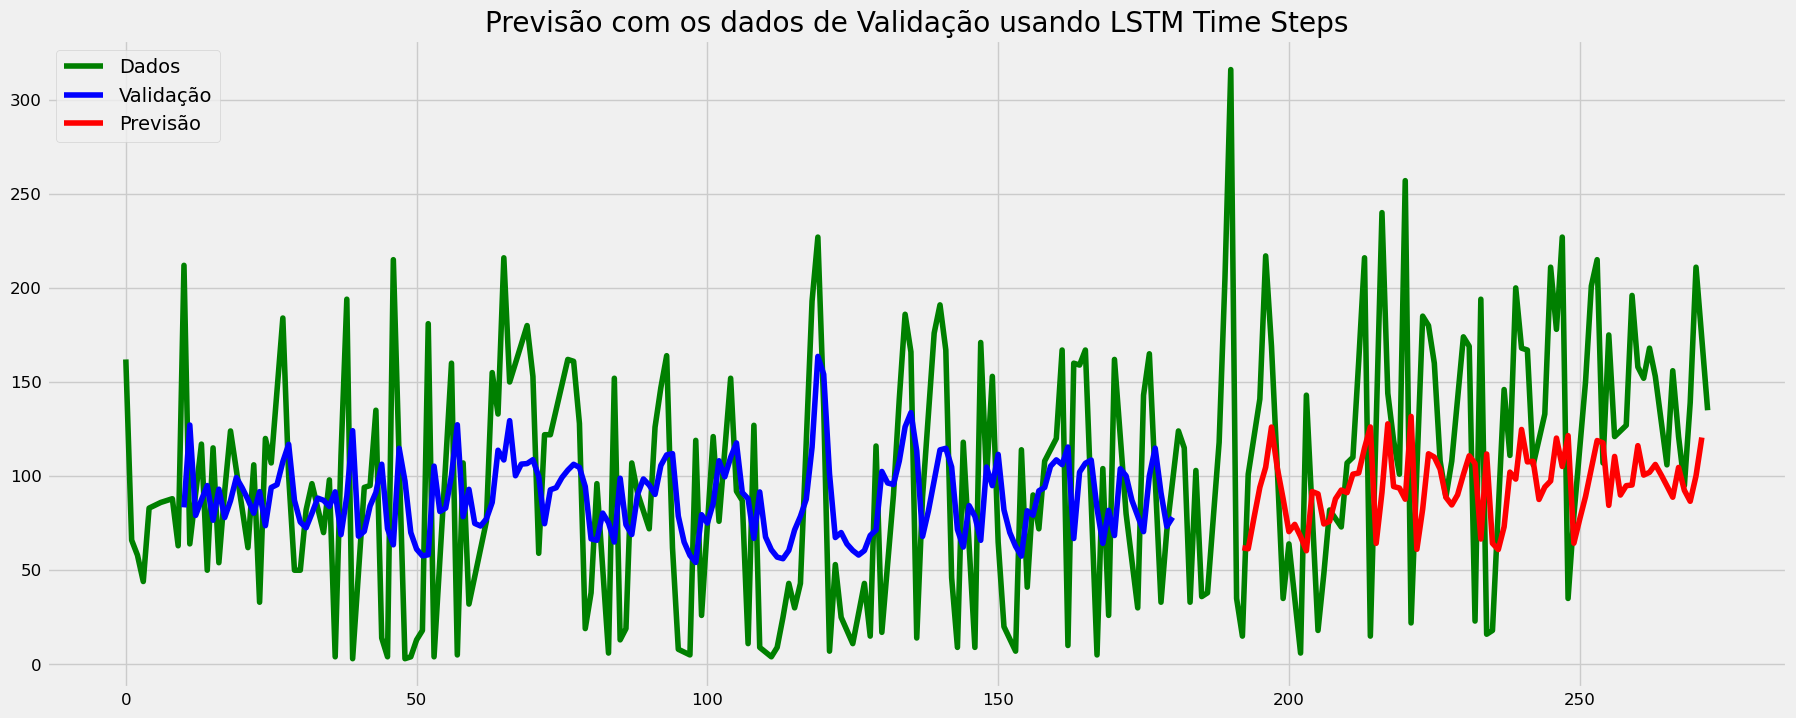

In [26]:
# Ajusta as previsões em treino para o plot
trainPredictPlot = numpy.empty_like(dataset)
trainPredictPlot[:, :] = numpy.nan
trainPredictPlot[look_back:len(trainPredict)+look_back, :] = trainPredict

# Ajusta as previsões em validação para o plot
validPredictPlot = numpy.empty_like(dataset)
validPredictPlot[:, :] = numpy.nan
validPredictPlot[len(trainPredict)+(look_back*2)+1:len(dataset)-1, :] = validPredict

# Plot do baseline e previsões
plt.figure(figsize = (20, 8))
plt.title("Previsão com os dados de Validação usando LSTM Time Steps") 
plt.plot(scaler.inverse_transform(dataset), label = 'Dados', color = 'green')
plt.plot(trainPredictPlot, color = 'blue', label = 'Validação')
plt.plot(validPredictPlot, color = 'red', label = 'Previsão')
plt.legend(loc = 'upper left') 
plt.show()

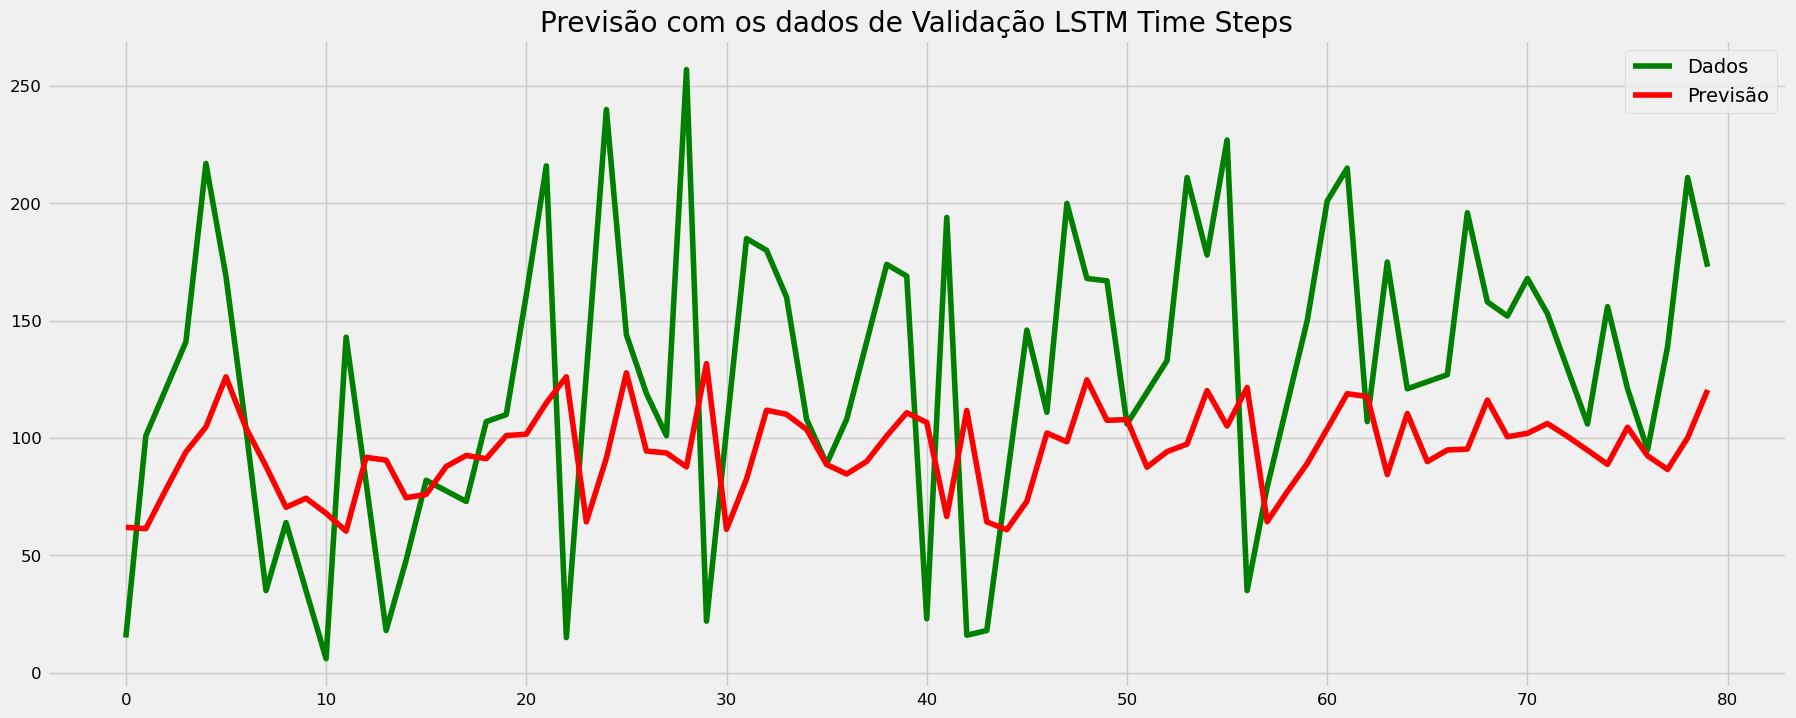

In [27]:
# Plot do baseline e previsões
plt.figure(figsize = (20, 8))
plt.title("Previsão com os dados de Validação LSTM Time Steps") 
plt.plot(validY[0], label = 'Dados', color = 'green') 
plt.plot(validPredict[:,0], label = 'Previsão', color = 'red') 
plt.legend(loc = 'best') 
plt.show()

In [28]:
# Carregando os dados
datasetfull = dataframe.copy()

filtro1 = datasetfull['Broker']=='ETB170'
filtro2 = datasetfull['Service_name']=='PORTALDETRAN'
filtro3 = datasetfull['Programa']=='NSDGX500'
datasetfull = datasetfull[filtro1 & filtro2 & filtro3]

datasetfull = datasetfull.rename_axis('index').reset_index()
datasetfull.drop(columns=['index','Broker','Service_name','Service_class','Programa'], inplace=True)

datasetfull.drop_duplicates(subset='Data', inplace=True)
datasetfull = datasetfull.set_index('Data')
datasetfull = datasetfull.resample('D').interpolate()

datasetfull = datasetfull.values
datasetfull = datasetfull.astype('float32')

# Split em treino e teste
train_size = int(len(datasetfull) * 0.75)
test_size = len(datasetfull) - train_size
dataset, test = datasetfull[0:train_size,:], datasetfull[train_size:len(datasetfull),:]

# Normaliza os dados
scaler = MinMaxScaler(feature_range = (0, 1))
dataset = scaler.fit_transform(dataset)

# Normaliza os dados de Teste
scalerTeste = MinMaxScaler(feature_range = (0, 1))
testScaler = scalerTeste.fit_transform(test)

# Split em treino e validação
train_size = int(len(dataset) * 0.67)
valid_size = len(dataset) - train_size
train, valid = dataset[0:train_size,:], dataset[train_size:len(dataset),:]

# Reshape em X=t e Y=t+1
trainX, trainY = create_dataset(train, look_back)
validX, validY = create_dataset(valid, look_back)
testX, testY = create_dataset(testScaler, look_back)

# Reshape do input para: [samples, time steps, features]
# Time steps
trainX = numpy.reshape(trainX, (trainX.shape[0], trainX.shape[1], 1))
validX = numpy.reshape(validX, (validX.shape[0], validX.shape[1], 1))
testX = numpy.reshape(testX, (testX.shape[0], testX.shape[1], 1))

In [29]:
#carrega o modelo
model = load_model(os.path.join(save_path,"RNN02_PipaMainframe_LSTM_Time_Steps.h5"))

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 4)                 96        
                                                                 
 dense (Dense)               (None, 1)                 5         
                                                                 
Total params: 101
Trainable params: 101
Non-trainable params: 0
_________________________________________________________________


In [30]:
# Previsões
trainPredict = model.predict(trainX)
validPredict = model.predict(validX)
testPredict = model.predict(testX)

3/3 [==============================] - 0s 4ms/step


In [31]:
# Inverte as previsões por conta da normalização
trainPredict = scaler.inverse_transform(trainPredict)
trainY = scaler.inverse_transform([trainY])
validPredict = scaler.inverse_transform(validPredict)
validY = scaler.inverse_transform([validY])
testPredict = scalerTeste.inverse_transform(testPredict)
testY = scalerTeste.inverse_transform([testY])

In [32]:
# Calcula o RMSE
trainScore = math.sqrt(mean_squared_error(trainY[0], trainPredict[:,0]))
print('Score em Treino: %.4f RMSE' % (trainScore))
validScore = math.sqrt(mean_squared_error(validY[0], validPredict[:,0]))
print('Score em Validação: %.4f RMSE' % (validScore))
testScore = math.sqrt(mean_squared_error(testY[0], testPredict[:,0]))
print('Score em Teste: %.4f RMSE' % (testScore))

Score em Treino: 55.3229 RMSE
Score em Validação: 65.7431 RMSE
Score em Teste: 82.1498 RMSE


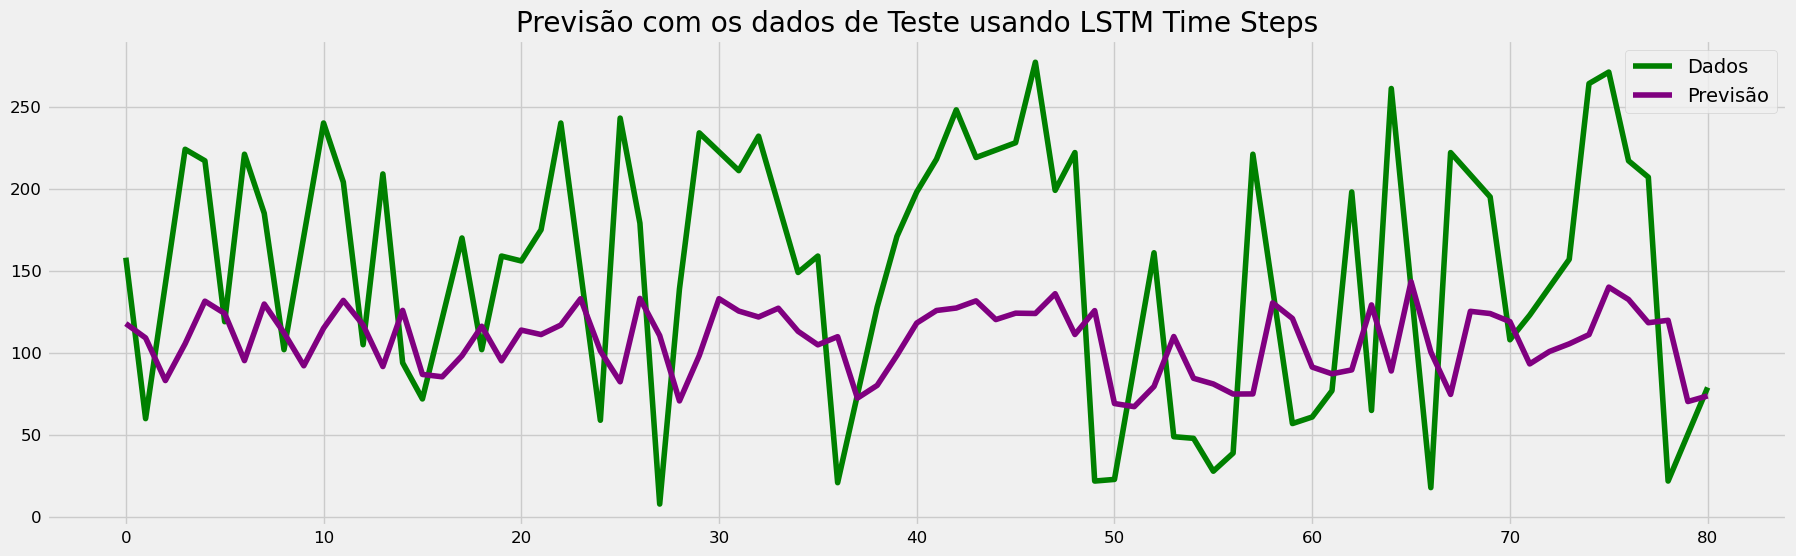

In [33]:
# Plot do baseline e previsões
plt.figure(figsize = (20, 6))
plt.title("Previsão com os dados de Teste usando LSTM Time Steps") 
plt.plot(testY[0], label = 'Dados', color = 'green') 
plt.plot(testPredict[:,0], label = 'Previsão', color = 'purple') 
plt.legend(loc = 'best') 
plt.show()

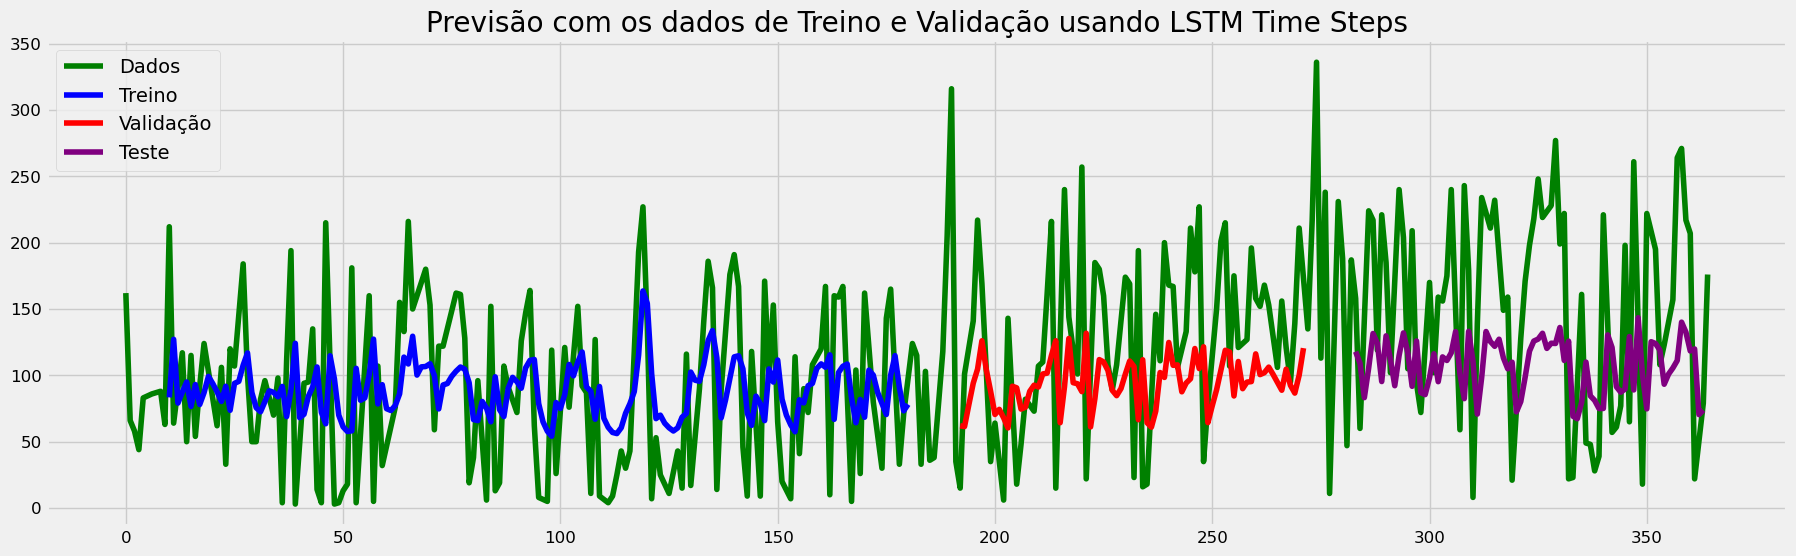

In [34]:
# Ajusta as previsões em treino para o plot
trainPredictPlot = numpy.empty_like(datasetfull)
trainPredictPlot[:, :] = numpy.nan
trainPredictPlot[look_back:len(trainPredict)+look_back, :] = trainPredict

# Ajusta as previsões em validação para o plot
validPredictPlot = numpy.empty_like(dataset)
validPredictPlot[:, :] = numpy.nan
validPredictPlot[len(trainPredict)+(look_back*2)+1:len(dataset)-1, :] = validPredict             

# Ajusta as previsões em validação para o plot
testPredictPlot = numpy.empty_like(datasetfull)
testPredictPlot[:, :] = numpy.nan
testPredictPlot[(len(trainPredict) + len(validPredict))+(look_back*3)+2:len(datasetfull)-1, :] = testPredict

# Plot do baseline e previsões
plt.figure(figsize = (20, 6))
plt.title("Previsão com os dados de Treino e Validação usando LSTM Time Steps") 
plt.plot(datasetfull, label = 'Dados',color = 'green')
plt.plot(trainPredictPlot, label = 'Treino', color = 'blue')
plt.plot(validPredictPlot, label = 'Validação', color = 'red')
plt.plot(testPredictPlot, label = 'Teste', color = 'purple')
plt.legend(loc = 'upper left') 
plt.show()

<a id='etapa5'></a>
## Etapa 5: Realizar as Previsões

## Vamos fazer o Forecasting para 82 dias de previsão

In [35]:
# Carregando os dados
datasetfull = dataframe.copy()

filtro1 = datasetfull['Broker']=='ETB170'
filtro2 = datasetfull['Service_name']=='PORTALDETRAN'
filtro3 = datasetfull['Programa']=='NSDGX500'
datasetfull = datasetfull[filtro1 & filtro2 & filtro3]

datasetfull.drop(columns=['Broker','Service_name','Service_class','Programa'], inplace=True)

datasetfull.drop_duplicates(subset='Data', inplace=True)
datasetfull = datasetfull.set_index('Data')
datasetfull = datasetfull.resample('D').interpolate()

# Refinamos os dados para o gráfico da série original
# A variável Quantidade é nossa variável target 
target = datasetfull['Quantidade']
raw_values = target.values

datasetfull = datasetfull.values
datasetfull = datasetfull.astype('float32')

# Split em treino e teste
train_size = int(len(datasetfull) * 0.75)
test_size = len(datasetfull) - train_size
dataset, test = datasetfull[0:train_size,:], datasetfull[train_size:len(datasetfull),:]

# Normaliza os dados
scaler = MinMaxScaler(feature_range = (0, 1))
dataset = scaler.fit_transform(dataset)

# Normaliza os dados de Teste
scalerTeste = MinMaxScaler(feature_range = (0, 1))
testScaler = scalerTeste.fit_transform(test)

# Split em treino e validação
train_size = int(len(dataset) * 0.67)
valid_size = len(dataset) - train_size
train, valid = dataset[0:train_size,:], dataset[train_size:len(dataset),:]

# Reshape em X=t e Y=t+1
trainX1, trainY = create_dataset(train, look_back)
validX1, validY = create_dataset(valid, look_back)
testX1, testY = create_dataset(testScaler, look_back)

# Reshape do input para: [samples, time steps, features]
trainX = numpy.reshape(trainX1, (trainX1.shape[0], trainX1.shape[1], 1))
validX = numpy.reshape(validX1, (validX1.shape[0], validX1.shape[1], 1))
testX = numpy.reshape(testX1, (testX1.shape[0], testX1.shape[1], 1))

In [36]:
#carrega o modelo
model = load_model(os.path.join(save_path,"RNN02_PipaMainframe_LSTM_Time_Steps.h5"))

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 4)                 96        
                                                                 
 dense (Dense)               (None, 1)                 5         
                                                                 
Total params: 101
Trainable params: 101
Non-trainable params: 0
_________________________________________________________________


In [37]:
# Fazemos uma previsão em uma etapa
def forecast_lstm(model, X):
    X = X.reshape(1, look_back, 1)
    yhat = model.predict(X)
    yhat1 = scaler.inverse_transform(yhat)
    return yhat1[0,0]

In [38]:
# Validação direta nos dados de teste

# Lista para as previsões
previsoes_lstm = list()

# Previsões

for i in range(len(testX1)):   
   
    # Ajusta o shape dos dados de teste
    X, y = testX1[i], testY[i]
    
    # Previsão

    yhat = forecast_lstm(model, X)
    
    # Armazena o forecast
    previsoes_lstm.append(yhat)
    expected = raw_values[len(testX1) + i ]
    
    print('Mês = %d, Valor Previsto = %f, Valor Esperado = %f' % (i + 1, yhat, expected))

1/1 [==============================] - 0s 429ms/step
Mês = 1, Valor Previsto = 107.848000, Valor Esperado = 96.000000
1/1 [==============================] - 0s 26ms/step
Mês = 2, Valor Previsto = 99.524757, Valor Esperado = 51.000000
1/1 [==============================] - 0s 26ms/step
Mês = 3, Valor Previsto = 74.741425, Valor Esperado = 6.000000
1/1 [==============================] - 0s 27ms/step
Mês = 4, Valor Previsto = 96.182411, Valor Esperado = 152.000000
1/1 [==============================] - 0s 26ms/step
Mês = 5, Valor Previsto = 120.878723, Valor Esperado = 13.000000
1/1 [==============================] - 0s 27ms/step
Mês = 6, Valor Previsto = 113.721947, Valor Esperado = 19.000000
1/1 [==============================] - 0s 27ms/step
Mês = 7, Valor Previsto = 86.333618, Valor Esperado = 107.000000
1/1 [==============================] - 0s 27ms/step
Mês = 8, Valor Previsto = 119.212776, Valor Esperado = 91.000000
1/1 [==============================] - 0s 26ms/step
Mês = 9, Valor

1/1 [==============================] - 0s 28ms/step
Mês = 71, Valor Previsto = 109.006142, Valor Esperado = 20.000000
1/1 [==============================] - 0s 28ms/step
Mês = 72, Valor Previsto = 84.404457, Valor Esperado = 13.500000
1/1 [==============================] - 0s 27ms/step
Mês = 73, Valor Previsto = 91.642502, Valor Esperado = 7.000000
1/1 [==============================] - 0s 62ms/step
Mês = 74, Valor Previsto = 96.081932, Valor Esperado = 114.000000
1/1 [==============================] - 0s 32ms/step
Mês = 75, Valor Previsto = 101.449715, Valor Esperado = 41.000000
1/1 [==============================] - 0s 28ms/step
Mês = 76, Valor Previsto = 129.046692, Valor Esperado = 90.000000
1/1 [==============================] - 0s 32ms/step
Mês = 77, Valor Previsto = 121.840752, Valor Esperado = 72.000000
1/1 [==============================] - 0s 26ms/step
Mês = 78, Valor Previsto = 108.349800, Valor Esperado = 108.000000
1/1 [==============================] - 0s 29ms/step
Mês = 

In [39]:
# Última data da série
target.index[-1]

Timestamp('2022-10-25 00:00:00', freq='D')

In [40]:
# Cria sequência de datas a partir da última data da nossa série original
datas_para_prever_forecasting = [target.index[-1] + DateOffset(days = x) for x in range(0, 82)]

In [41]:
# Objetos do tipo pd.Series dão mais trabalho para manipular. Vamos converter a série original em dataframe.
df_original = pd.DataFrame(target)

In [42]:
# Vamos agora criar um novo dataframe 
# O índice (data) será a sequência de datas futuras
# O nome da coluna de dados extraímos da série original
# ATENÇÃO: Não estamos extraindo os dados da série original, somente o nome da coluna
data_futuras = pd.DataFrame(index = datas_para_prever_forecasting[1:], columns = df_original.columns)

In [43]:
# Visualiza os dados
# Entendeu por que os valores NaN? São datas futuras, e precisamos agora incluir nossas previsões.
data_futuras

,Quantidade
2022-10-26,NaN
2022-10-27,NaN
2022-10-28,NaN
2022-10-29,NaN
2022-10-30,NaN
...,...
2023-01-10,NaN
2023-01-11,NaN
2023-01-12,NaN
2023-01-13,NaN


In [44]:
# Usamos as datas futuras para extrair as previsões do nosso modelo
df_predict = pd.DataFrame(testPredict,
                          index = data_futuras.index, columns = ['Prediction'])

In [45]:
df_predict

,Prediction
2022-10-26,117.872665
2022-10-27,109.150543
2022-10-28,83.179512
2022-10-29,105.648026
2022-10-30,131.527863
...,...
2023-01-10,132.535995
2023-01-11,118.398506
2023-01-12,119.877899
2023-01-13,70.415520


In [46]:
# Concatenamos a série original com os valores de forecasting de 82 dias além da série
df_forecasting = pd.concat([df_original, df_predict], axis = 1)

In [47]:
df_forecasting.to_csv(r'./CSV/PipaMainframe_Forecasting_Time_Steps.csv', index = False)

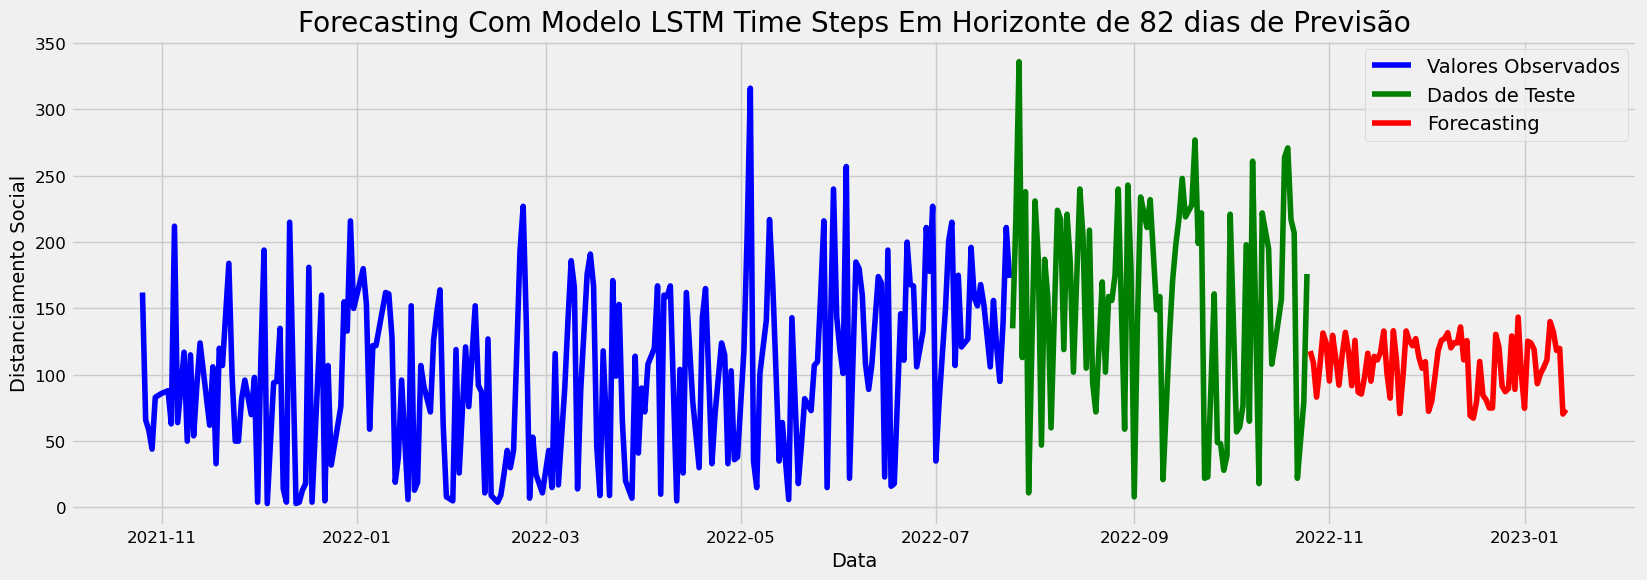

In [51]:
# Plot
plt.figure(figsize = (18, 6))

# Série original
plt.plot(target.index[0:272], target.values[0:272], label = 'Valores Observados', color = 'Blue')
plt.plot(target.index[272:], target.values[272:], label = 'Dados de Teste', color = 'green')

# Previsões
plt.plot(df_forecasting.index, df_forecasting['Prediction'], label = 'Forecasting',  color = 'Red')

plt.title('Forecasting Com Modelo LSTM Time Steps Em Horizonte de 82 dias de Previsão')
plt.xlabel('Data')
plt.ylabel('Distanciamento Social')
plt.legend()
plt.show()

Todas as aulas deste curso foram adaptadas da timeline da Comunidade no Portal da DSA: www.datascienceacademy.com.br

# Fim